# Recommendation Method 1: Most similar items to user's previous views 

### Algorithm 
Offline: 
1. For each item, calculate features on trained neural network $ f_j $
2. For each user, look up previous views and average the features together of the previous visit $ f_i = \sum_j f_j*I(i,j) $
3. Store the features of the 'typical' item viewed by this user. 
4. Calculate similarity of all items to user's 'typical item', store as a recommend list

Online: 
1. User comes to website
2. Recommend the top 20 items from his recommend list. 





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

#### FUNCTIONS HERE 

### Evaluation 

How well does nathan's algorithm work? 

- get a small set of trajectories. Maybe 100 people. 
- seperate out the buy items. 
- remove the items that are on the same day. 
- calculate typcial images for day 1. 
- make recommend list. 
- calculate score. 

In [3]:
# load smaller user behavior dataset

user_profile = pd.read_pickle('../data_user_view_buy/user_profile_items_nonnull_features_20_mins_5_views.pkl')

In [4]:
user_profile.head()

,user_id,buy_spu,buy_sn,buy_ct3,view_spu,view_sn,view_ct3,time_interval,view_cnt,view_seconds,index,spu_id,features,view_spu_count
89,960980006,2463545257346113536,10015294,334,107318456632717316,10015294,334,17345,1,5,69776.0,1.073185e+17,"[0.31, 0.741, 0.066, 0.868, 0.266, 0.0, 0.086,...",139
90,960980006,2463545257346113536,10015294,334,107318460592529411,10007066,334,193314,1,5,17665.0,1.073185e+17,"[0.0, 2.812, 0.284, 0.462, 0.002, 0.0, 0.417, ...",139
91,960980006,2463545257346113536,10015294,334,1376488951765147648,10015294,334,449577,2,43,51881.0,1.376489e+18,"[0.563, 0.661, 0.162, 0.813, 0.149, 0.899, 0.5...",139
92,960980006,2463545257346113536,10015294,334,1600824511410274307,10015294,334,450245,1,7,53203.0,1.600825e+18,"[0.421, 0.454, 0.0, 0.295, 1.546, 0.36, 0.102,...",139
93,960980006,2463545257346113536,10015294,334,1683296679586492416,10015294,334,16038,1,9,66087.0,1.683297e+18,"[0.144, 1.025, 0.064, 1.208, 0.117, 0.205, 0.3...",139


In [5]:
# load item features (indexed by spu)

spu_fea = pd.read_pickle("../data_nn_features/spu_fea.pkl") #takes forever to load 

In [6]:
len(user_profile)

544913

In [7]:
users = user_profile.user_id.unique()
len(users)

11903

In [8]:
len(user_profile.buy_sn.unique())

354

In [11]:
# sample 100 users 
users_sample = np.random.choice(users,size=100)
user_profile_sample = user_profile.loc[user_profile.user_id.isin(users_sample),]
len(user_profile_sample)

4086

In [16]:
users_sample 

array([2581027832, 3503854236, 3758098940, 1169143983, 2508730194,
       1907032321, 2822851439,  104311187, 2642855428, 1964791361,
       3530852975, 2113211132,  675264603,  799326934,  679859279,
       2622890341, 3611367554, 1502467292, 3995273329, 1663333100,
        334201454, 4112435641, 2454966700,  143297995,  673923390,
       3819587167, 1447848884, 2991695787, 3550219249,  502540768,
       1895808200, 1508155242, 3993209019,  316997944, 1120005731,
       4174229541, 2213541420, 1568508247,  657254176, 2204551923,
         60285527,  540939119, 2795527501, 4154003785, 2550464364,
       3620762608, 3486986763, 1880832286, 3130808332,  339166521,
       3981617737,  541950412, 2540470338, 2846785931,  384391795,
       3577405008,  249975986, 2452551846, 1969000852,  620775412,
       1793214582, 2282508800, 3689671362,  223850579, 3449576465,
        523482920, 3757876886, 3160131042, 3763327631,   30219851,
       1535889322, 3370108602, 1387486416, 2299263459, 3492335

In [12]:
# make a function for each user?? 

user_buy_dict = {}
average_viewed_features_dict = {}

# loop through users 
for user_id in users_sample:
    
    # get his trajectory 
    trajectory = user_profile_sample.loc[user_profile_sample.user_id==user_id,]

    # save buy image
    user_buy_dict[user_id] = trajectory.buy_spu.as_matrix()[0]
    
    # save buy category 
    
    
    # remove buy item
    trajectory = trajectory.loc[trajectory.view_spu!=user_buy_dict[user_id]]
    
    
    n_features = len(spu_fea.features.as_matrix()[0])
    n_views = len(trajectory)
    
    # get previous views
    features_items = np.empty((n_features,n_views))
    for vi,view_spu in enumerate(trajectory.view_spu):
        
        # load features for image
        if view_spu in spu_fea.spu_id.values:
            features_items[:,vi] = spu_fea.loc[spu_fea.spu_id==view_spu,'features'].as_matrix()[0] # return a 1-D np array 
        else:
            # this shouldn't happen 
            raise ValueError('all items should have features')
            features_items[:,vi] = np.ones(n_features) # if features don't exist for an item, add array of ones (shouldn't change average)
    # average features
    average_viewed_features_dict[user_id] = np.mean(features_items,axis=1)
    


In [14]:
#average_viewed_features_dict

In [15]:
def dot(K, L):
    if len(K) != len(L): return 0
    return sum(i[0]*i[1] for i in zip(K, L))

def similarity(item_1, item_2):
        return dot(item_1, item_2) / np.sqrt(dot(item_1, item_1)*dot(item_2, item_2))

In [17]:
# for each user 
user_buy_ranks = np.empty(len(users_sample))
no_ranks = np.empty(len(users_sample))
for ui,user_id in enumerate(users_sample):
    print(ui)
    # load average trajectory 
    average_features = average_viewed_features_dict[user_id]
    
    # get bought item
    buy_spu = user_buy_dict[user_id]
    
    # find buy item categoriy 
    buy_sn = user_profile_sample.loc[user_profile_sample['buy_spu']==buy_spu,'buy_sn'].as_matrix()[0] # should assert they are all the same
    
    # find all other items in the category
    spus_in_category_b = user_profile.loc[user_profile.buy_sn==buy_sn,'buy_spu'].unique() 
    spus_in_category_v = user_profile.loc[user_profile.view_sn==buy_sn,'view_spu'].unique() 
    spus_in_category = list(spus_in_category_b)+list(spus_in_category_v)
    
    # make sure buy item is in list
    assert buy_spu in spus_in_category
    
    # does it make sense to pre-calculate this matrix of similarities (average user similarity for each bought item)  # 
    
    # calculate similarity with all candidate in buy items 
    item_sim_in_category = pd.DataFrame(data = spus_in_category,columns=['spu'])
    for spu in spus_in_category:
        
        # load features for image
        features_other = spu_fea.loc[spu_fea.spu_id==spu,'features'].as_matrix()[0] # return a 1-D np array  
        item_sim_in_category.loc[item_sim_in_category['spu']==spu,'similarity']= similarity(average_features,features_other)
    
    item_sim_in_category['rank']=item_sim_in_category['similarity'].rank()    

    user_buy_ranks[ui]=item_sim_in_category.loc[item_sim_in_category.spu==buy_spu,'rank'].as_matrix()[0]
    no_ranks[ui]=item_sim_in_category['rank'].max()


    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [18]:
item_sim_in_category.sort_values(by='rank')

,spu,similarity,rank
6,456628921179025409,0.628445,1.0
13,20905657232343047,0.744620,2.0
8,5706008489967619,0.759643,3.0
22,458880713561350165,0.767476,4.0
9,33009059997233308,0.788442,5.0
2,3735683652993028,0.795370,6.0
20,441992214958710797,0.801106,7.0
15,441710732886978570,0.814434,8.0
14,462539888258588697,0.816877,9.0
4,22031535905517703,0.817633,10.0


In [19]:
user_buy_ranks[ui]

13.5

In [20]:
item_sim_in_category['rank'].max()
item_sim_in_category['rank'].unique()

array([ 22.5,  13.5,   6. ,  10. ,  21. ,   1. ,  16. ,   3. ,   5. ,
        24. ,  25. ,  12. ,   2. ,   9. ,   8. ,  19. ,  17. ,  20. ,
        18. ,   7. ,   4. ,  15. ,  11. ])

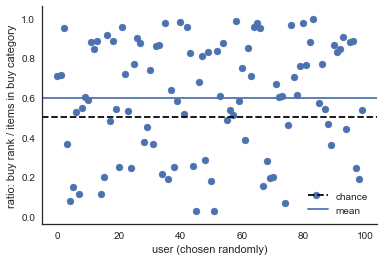

In [33]:
# plt.subplot(1,3,1)
# plt.scatter(np.arange(len(users_sample)),user_buy_ranks)
# plt.subplot(1,3,2)
# plt.scatter(np.arange(len(users_sample)),no_ranks)
plt.subplot(1,1,1)
plt.scatter(np.arange(len(users_sample)),user_buy_ranks/no_ranks)
sns.despine()
plt.axhline(y=0.5,label='chance',c='k',linestyle='--')
plt.axhline(y=np.mean(user_buy_ranks/no_ranks),label='mean')
plt.legend()
plt.xlabel('user (chosen randomly)')
plt.ylabel('ratio: buy rank / items in buy category')

### Generate Random Recomender

# Save

In [35]:
%%bash 
jupyter nbconvert --to slides Recommendor_Method_Nathans.ipynb && mv Recommendor_Method_Nathans.slides.html ../notebook_slides/Recommendor_Method_Nathans_v1.slides.html
jupyter nbconvert --to html Recommendor_Method_Nathans.ipynb && mv Recommendor_Method_Nathans.html ../notebook_htmls/Recommendor_Method_Nathans_v1.html
cp Recommendor_Method_Nathans.ipynb ../notebook_versions/Recommendor_Method_Nathans_v1.ipynb

[NbConvertApp] Converting notebook Recommendor_Method_Nathans.ipynb to slides
[NbConvertApp] Writing 301358 bytes to Recommendor_Method_Nathans.slides.html
[NbConvertApp] Converting notebook Recommendor_Method_Nathans.ipynb to html
[NbConvertApp] Writing 306926 bytes to Recommendor_Method_Nathans.html
